# pycontrails Architecture

- Authors: Marc Shapiro, Zeb Engberg
- Date: 2023-04-14
- `pycontrails`: v0.39.6

Review the design philosophy and package architecture of `pycontrails`.

### References

- [Repository](https://gitlab.com/contrails/pycontrails)
- Current [installation instructions](https://gitlab.com/contrails/pycontrails#develop)
- This demo assumes you have a working knowledge of [Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) and [xarray](https://xarray.pydata.org/en/stable/index.html) libraries.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/contrailcirrus/2023-04-pycontrails-workshop/blob/main/notebooks/01-pycontrails-Architecture.ipynb)

In [ ]:
!pip install pycontrails
!pip install "pycontrails[ecmwf]"
!pip install "pycontrails[vis]"

In [1]:
import pathlib  # OS path support

import pandas as pd
import numpy as np
import xarray as xr

# Flight Handling

### Flight class

The `Flight` class is a wrapper around a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).
You can access the underlying `DataFrame` using the `data` attribute:

```python
flight = Flight(...)
df = flight.data    # type pandas.DataFrame
```

In [2]:
from pycontrails import Flight

In [3]:
? Flight

Init signature:
 Flight(
    data: 'dict[str, np.ndarray] | None' = None,
    longitude: 'np.ndarray | None' = None,
    latitude: 'np.ndarray | None' = None,
    altitude: 'np.ndarray | None' = None,
    time: 'np.ndarray | None' = None,
    attrs: 'dict[str, Any] | None' = None,
    copy: 'bool' = True,
    aircraft: 'Aircraft | None' = None,
    **attrs_kwargs: 'Any',
) -> 'None'
Docstring:     
A single flight trajectory.

Expect latitude-longitude CRS in WGS 84.
Expect altitude in [:math:`m`].
Expect level in [:math:`hPa`].

Use the attribute :attr:`attrs["crs"]` to specify coordinate reference system
using `PROJ <https://proj.org/>`_ or `EPSG <https://epsg.org/home.html>`_ syntax.

Parameters
----------
data : dict[str, np.ndarray] | pd.DataFrame
    Flight trajectory waypoints as data dictionary or :class:`pandas.DataFrame`.
    Must include columns ``time``, ``latitude``, ``longitude``, ``altitude`` or ``level``.
    Keyword arguments for ``time``, ``latitude``, ``longitude``, 

### Aircraft Class

> This is currently a very thin dataclass without much functionality.
> We may decide this is overkill and that all `Aircraft` class functionality should be rolled into the `Flight` class

> This is not currently used in this demo, but here for discussion

In [4]:
from pycontrails import Aircraft

In [5]:
? Aircraft

Init signature:
 Aircraft(
    aircraft_type: 'str | None' = None,
    aircraft_name: 'str | None' = None,
    wingspan: 'float | None' = None,
    engine_name: 'str | None' = None,
    n_engine: 'int | None' = None,
    max_mach: 'float | None' = None,
    max_altitude: 'float | None' = None,
) -> None
Docstring:      Base class for the physical parameters of the aircraft.
File:           ~/computing/daitem/contrails/pycontrails/pycontrails/core/flight.py
Type:           type
Subclasses:     


### Load data from Shanwick

Name of the airspace in North Atlantic

In [6]:
filename = "Shanwick_Wypts_2019_01_01.csv"

In [41]:
def create_flight(flight_id, df_flight):
    """
    Function to create a Flight class from a 
    group of rows with the same Flight ID
    """

    # constant properties along the length of the flight
    flight_attrs = {
        "flight_id": flight_id,
        
        # get first val of atyp col as aircraft type
        "aircraft_type": df_flight["ATYP"].values[0]
    }
    
    # # DISCUSSION: We could use the Aircraft class here
    # aircraft = Aircraft(aircraft_type=df_flight["ATYP"].values[0])
    
    # convert UTC timestamp to np.datetime64
    df_flight["time"] = pd.to_datetime(df_flight["date_time"])

    # get altitude in m
    df_flight["altitude"] = df_flight["alt_ft"] * 0.3048

    # rename a few columns for compatibility with `Flight` requirements
    df_flight = df_flight.rename(columns={"lon_deg": "longitude", "lat_deg": "latitude"})

    # clean up a few columns before building Flight class
    df_flight = df_flight.drop(columns=["Flight ID", "date_time", "ATYP", "alt_ft"])

    # create a Flight class
    return Flight(df_flight, attrs=flight_attrs)

In [42]:
# read source CSV data
df = pd.read_csv(filename)

# create a list of flights from each Flight ID in dataframe
flights = [
    create_flight(flight_id, df_flight) 
    for (flight_id, df_flight) in df.groupby("Flight ID")
]

In [43]:
# visualize single flight
flights[10]

Flight [5 keys x 69 length, 3 attributes]
	Keys: wypt_id, longitude, latitude, time, altitude
	Attributes:
	time                ['2019-01-01 00:00:24', '2019-01-01 01:08:51']
	longitude           [-50.0, -32.43764995868504]
	latitude            [56.32050021513943, 57.09340622823786]
	altitude            [9753.6, 9753.6]
	flight_id           181231_1068_BOX390
	aircraft_type       B77L
	crs                 EPSG:4326

# Met Handling

The base class for Meteorology data is `MetDataset` or `MetDataArray`.
These are wrappers around [`xarray.Dataset`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) and [`xarray.DataArray`](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html), respectively.

You can access the underlying `Dataset` or `DataArray` using the `data` attribute:

```python
met = MetDataset(...)
ds = met.data    # type xarray.Dataset

met = MetDataArray(...)
da = met.data    # type xarray.DataArray
```

In [10]:
from pycontrails import MetDataset, MetDataArray

In [11]:
? MetDataset

Init signature:
 MetDataset(
    data: 'xr.Dataset',
    cachestore: 'CacheStore' = DiskCacheStore: /Users/marcus/Library/Caches/pycontrails,
    wrap_longitude: 'bool' = False,
    copy: 'bool' = True,
)
Docstring:     
Meteorological dataset with multiple variables.

Composition around :class:`xarray.Dataset` to enforce certain
variables and dimensions for internal usage

Parameters
----------
data : :class:`xarray.Dataset`
    :class:`xarray.Dataset` containing meteorlogical variables and coordinates
cachestore : :class:`CacheStore`, optional
    Cache datastore for staging intermediates with :meth:`save`.
    Defaults to :class:`DiskCacheStore`.
wrap_longitude : bool, optional
    Wrap data along the longitude dimension.
    Defaults to True.

Examples
--------
>>> import numpy as np
>>> import pandas as pd
>>> import xarray as xr
>>> from pycontrails.datalib import ERA5

>>> time = ("2020-01-01T00", "2020-01-01T02")
>>> variables = ["temperature", "relative_humidity", "specific_hu

In [12]:
? MetDataArray

Init signature:
 MetDataArray(
    data: 'ArrayLike',
    cachestore: 'CacheStore' = DiskCacheStore: /Users/marcus/Library/Caches/pycontrails,
    wrap_longitude: 'bool' = False,
    copy: 'bool' = True,
    validate: 'bool' = True,
    **kwargs: 'Any',
) -> 'None'
Docstring:     
Meteorological DataArray of single variable.

Wrapper around :class:`xarray.DataArray` to enforce certain
variables and dimensions for internal usage.
Init docstring:
Initialize a `MetDataArray.

Parameters
----------
data : ArrayLike
    :class:`xarray.DataArray` or other array-like data source.
    When array-like input is provided, input ``**kwargs`` passed directly to
    :class:`xarray.DataArray` constructor.
cachestore : :class:`CacheStore`, optional
    Cache datastore for staging intermediates with :meth:`save`.
    Defaults to :class:`DiskCacheStore`.
wrap_longitude : bool, optional
    Wrap data along the longitude dimension.
    Defaults to `True`.
copy : bool, optional
    Copy `data` parameter on

### ECMWF Support

`pycontrails` includes data libraries for accessing meteorology from ECMWF.

These classes will help download and interpret data from the public ECMWF data endpoints.

In [14]:
from pycontrails.datalib import ERA5, HRES, IFS

In [15]:
? IFS

Init signature:
 IFS(
    time: 'TimeInput',
    variables: 'VariableInput',
    pressure_levels: 'PressureLevelInput' = [-1],
    path: 'str | list[str] | None' = None,
    forecast_date: 'DatetimeLike' = None,
)
Docstring:     
 Class preprocesses the meteorological dataset from the
 ECMWF Integrated Forecasting System (IFS).

 Note this takes an average pressure of the model level to create
 pressure level dimensions

Parameters
 ----------
 time :  :type:`TimeInput`
     The time range for data retrieval, single datetime or [start, end] datetime range.
     Input must be a single datetime-like or tuple of datetime-like (datetime, :class:`pandas.Timestamp`, :class:`numpy.datetime64`)
     specifing the [start, end] of the date range, inclusive.
     The start time will be rounded down to the nearest synoptic hour: 00, 12.
     All subsequent times will be downloaded for the single forecast model run nearest to the start time (see :attr:`basetime`)
 variables : :type:`VariableInput`


In [16]:
? ERA5

Init signature:
 ERA5(
    time: 'TimeInput',
    variables: 'VariableInput',
    pressure_levels: 'PressureLevelInput' = [-1],
    path: 'str | list[str] | pathlib.Path | list[pathlib.Path] | None' = None,
    timestep_freq: 'str' = '1H',
    product_type: 'str' = 'reanalysis',
    grid: 'float' = 0.25,
    cachestore: 'cache.CacheStore' = DiskCacheStore: /Users/marcus/Library/Caches/pycontrails,
)
Docstring:     
Class to support ERA5 data access, download, and organization.

- Requires account with
`Copernicus Data Portal <https://cds.climate.copernicus.eu/cdsapp#!/home>`_
and  local ``~/.cdsapirc`` file with credentials.

Parameters
----------
time :  :type:`TimeInput`
    The time range for data retrieval, single datetime or [start, end] datetime range.
    Input must be a single datetime-like or tuple of datetime-like (datetime, :class:`pandas.Timestamp`, :class:`numpy.datetime64`)
    specifing the [start, end] of the date range, inclusive.
    Datafiles will be downloaded from 

### Read ECMWF Data from CDS

> Requires an account with [Copernicus Data Portal](https://cds.climate.copernicus.eu/cdsapp#!/home)

In [77]:
# get a range of time, use CF names
time_bounds = ("2019-01-01 00:00:00", "2019-01-01 03:00:00")
variables = ["air_temperature", "specific_humidity"]  # supports CF names
era5 = ERA5(time=time_bounds, variables=variables, pressure_levels=[350, 300])
era5

ERA5 (ECMWF)
	time: ('2019-01-01 00:00:00', '2019-01-01 03:00:00')
	variables: ['t', 'q']
	pressure levels: [350, 300]
	grid: 0.25
	dataset: reanalysis-era5-pressure-levels
	product_type: reanalysis

In [20]:
met = era5.open_metdataset()
met

MetDataset with data:

<xarray.Dataset>
Dimensions:            (longitude: 1440, latitude: 721, level: 2, time: 4)
Coordinates:
  * longitude          (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude           (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * level              (level) float64 300.0 350.0
  * time               (time) datetime64[ns] 2019-01-01 ... 2019-01-01T03:00:00
    air_pressure       (level) float64 3e+04 3.5e+04
    altitude           (level) float64 9.164e+03 8.117e+03
Data variables:
    air_temperature    (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 2, 1), meta=np.ndarray>
    specific_humidity  (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 2, 1), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-01 18:56:07 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

### Read ECMWF data locally

Interprets local ERA5 files using the `ERA5` class with `path` parameter

In [21]:
# read in Cocip model here to get access to variables
from pycontrails.models import Cocip

print(f"Pressure Level Variables:\n {Cocip.met_variables} \n")
print(f"Single Level Variables:\n {Cocip.rad_variables}")

Pressure Level Variables:
 ['air_temperature', 'specific_humidity', 'eastward_wind', 'northward_wind', 'lagrangian_tendency_of_air_pressure', 'specific_cloud_ice_water_content', 'geopotential'] 

Single Level Variables:
 ['top_net_solar_radiation', 'top_net_thermal_radiation']


In [44]:
time = ("2019-01-01 00:00:00", "2019-01-01 23:00:00")  # (start, end) inclusive time range
pressure_levels = [350, 300, 250, 225, 200, 175, 150]  # select pressure levels

# use pathlib here for cross platform compatibility
# assumes ERA5 data is in the current directory
path_prefix = pathlib.Path(".")

met_filepaths = [
    pathlib.Path(path_prefix / "ERA5_HRES_20190101_Met.nc"),
    pathlib.Path(path_prefix / "ERA5_HRES_20190102_Met.nc"),
]
rad_filepaths = [
    pathlib.Path(path_prefix / "ERA5_HRES_20190101_Rad.nc"),
    pathlib.Path(path_prefix / "ERA5_HRES_20190102_Rad.nc"),
]

In [45]:
# define ERA5 sources
era5pl = ERA5(time=time, 
              variables=Cocip.met_variables, 
              pressure_levels=pressure_levels, 
              path=met_filepaths)
era5sl = ERA5(time=time, 
              variables=Cocip.rad_variables, 
              path=rad_filepaths)

# create `MetDataset` from sources
mds = era5pl.open_metdataset()
rds = era5sl.open_metdataset()

In [46]:
mds

,Array,Chunk
Bytes,98.95 MiB,4.12 MiB
Shape,"(481, 321, 7, 24)","(481, 321, 7, 1)"
Count,218 Tasks,24 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,98.95 MiB,4.12 MiB
Shape,"(481, 321, 7, 24)","(481, 321, 7, 1)"
Count,218 Tasks,24 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [47]:
rds

,Array,Chunk
Bytes,14.14 MiB,603.13 kiB
Shape,"(481, 321, 1, 24)","(481, 321, 1, 1)"
Count,218 Tasks,24 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,14.14 MiB,603.13 kiB
Shape,"(481, 321, 1, 24)","(481, 321, 1, 1)"
Count,218 Tasks,24 Chunks
Type,float32,numpy.ndarray


# CoCip Model

In [48]:
from pycontrails.models import Cocip, CocipParams

In [49]:
# there params can be overridden via the `params` keyword in the Cocip class
? CocipParams

Init signature:
 CocipParams(
    bada3_path: 'str | pathlib.Path | None' = None,
    bada4_path: 'str | pathlib.Path | None' = None,
    process_met: 'bool' = True,
    process_emissions: 'bool' = True,
    dt_integration: 'np.timedelta64' = numpy.timedelta64(30,'m'),
    dz_m: 'float' = 200.0,
    effective_vertical_resolution: 'float' = 2000.0,
    shift_radiation_time: 'np.timedelta64' = numpy.timedelta64(-30,'m'),
    verbose_outputs: 'bool' = False,
    rhi_adj: 'float' = 1.0,
    rhi_boost_exponent: 'float' = 1.0,
    initial_wake_vortex_depth: 'float' = 0.5,
    sedimentation_impact_factor: 'float' = 0.5,
    default_bc_ei_n: 'float' = 1000000000000000.0,
    wind_shear_enhancement_exponent: 'float' = 0.5,
    bc_ei_n_enhancement_factor: 'float' = 1.0,
    min_ice_particle_number_bc_ei_n: 'float' = 10000000000000.0,
    min_altitude_m: 'float' = 6000.0,
    max_altitude_m: 'float' = 13000.0,
    max_seg_length_m: 'float' = 40000.0,
    max_age: 'np.timedelta64' = numpy.timedelt

In [50]:
? Cocip

Init signature:
 Cocip(
    met: 'MetDataset',
    rad: 'MetDataset',
    params: 'dict[str, Any]' = {},
    **params_kwargs: 'Any',
) -> 'None'
Docstring:     
Contrail Cirrus Prediction Model.

TODO: Add full CoCip documentation or link to here

Notes
-----
Implementation differs from Schumann in the following places.
    - Segment angle calculation for flights and contrail segments. See ``geo.segment_angles``.
    - Isobaric heat capacity calculation. See ``thermo.c_pm``.
    - End of life conventions for contrail continuity. See ``CONTINUITY_CONVENTION_PARAM``
    parameter.
    - Segment length ratio calculation. Instead of taking a geometric mean between the
    two segments adjacent to an interior waypoint, the current implementation associates
    each waypoint to the following segment. See ``contrail_properties.segment_length_ratio``.
    - Segment energy flux calculation. See ``contrail_properties.mean_energy_flux_per_m``.
    - Solar direct radiation. Original algorithm uses

### BADA Configuration

BADA is not included with `pycontrails`.
The user must configure the paths to BADA/EDB data on their local system

In [51]:
# use pathlib here for cross platform compatibility
# assumes `bada` folder is in the current directory
path_prefix = pathlib.Path("bada")

# these can also just be strings i.e. "bada/bada3"
bada3_path = pathlib.Path(path_prefix / "bada3")
bada4_path = pathlib.Path(path_prefix / "bada4")

### Run Model

Most of the time is taken in loading meteorology data

In [66]:
# the only parameters we will override here is the BADA paths
params = {
    "bada3_path": bada3_path,
    "bada4_path": bada4_path,
}

flight = flights[3] # select one flight from above

cocip = Cocip(met=mds, rad=rds, params=params)
out = cocip.eval(flight=flight)

### CoCip Ouputs

In [68]:
# output Flight and Flight data (pd.DataFrame)
cocip.flight.dataframe.head()

,wypt_id,longitude,latitude,time,altitude,flight_id,waypoint,air_temperature,specific_humidity,u_wind,...,n_ice_per_m_1,ef,sdr,rsr,olr,rf_sw,rf_lw,rf_net,cocip,contrail_age
0,118,-43.393592,56.086338,2019-01-01 00:00:34,9144.0,181231_1057_CKS244,0,224.869722,0.000017,-17.535201,...,7.351693e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,119,-43.655135,56.089109,2019-01-01 00:01:34,9144.0,181231_1057_CKS244,1,224.643972,0.000017,-17.768080,...,1.951975e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,120,-43.916712,56.091326,2019-01-01 00:02:34,9144.0,181231_1057_CKS244,2,224.389922,0.000016,-17.972747,...,2.149355e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,121,-44.178316,56.092988,2019-01-01 00:03:34,9144.0,181231_1057_CKS244,3,224.089630,0.000016,-18.189796,...,2.845076e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,122,-44.439938,56.094097,2019-01-01 00:04:34,9144.0,181231_1057_CKS244,4,223.718805,0.000016,-18.491877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [71]:
# output contrail waypoints (pd.DataFrame)
cocip.contrail.head()

,waypoint,flight_id,formation_time,time,longitude,latitude,altitude,level,continuous,segment_length,...,olr,rsr,sdr,rf_sw,rf_lw,rf_net,persistent,ef,timestep,age_hours
0,21,181231_1057_CKS244,2019-01-01 00:21:34,2019-01-01 00:30:00,-49.080469,56.095041,9091.588196,303.255098,True,14895.527623,...,143.193419,0.0,0.0,0.0,0.014982,0.014982,True,7.307341e+07,0,0.140556
1,22,181231_1057_CKS244,2019-01-01 00:22:34,2019-01-01 00:30:00,-49.319037,56.079964,9087.420196,303.443666,True,14867.096126,...,143.278054,0.0,0.0,0.0,0.225277,0.225277,True,6.637511e+08,0,0.123889
2,23,181231_1057_CKS244,2019-01-01 00:23:34,2019-01-01 00:30:00,-49.556881,56.064094,9084.390826,303.580780,True,14828.246071,...,143.391970,0.0,0.0,0.0,0.297474,0.297474,True,7.215516e+08,0,0.107222
3,24,181231_1057_CKS244,2019-01-01 00:24:34,2019-01-01 00:30:00,-49.793791,56.047300,9081.967048,303.690521,False,0.000000,...,143.699838,0.0,0.0,0.0,0.443410,0.443410,True,0.000000e+00,0,0.090556
0,21,181231_1057_CKS244,2019-01-01 00:21:34,2019-01-01 01:00:00,-49.775387,56.340322,9141.169715,301.019201,True,15026.495184,...,144.828963,0.0,0.0,0.0,0.454478,0.454478,True,2.196362e+10,1,0.640556


In [83]:
# look at the contrail waypoint from the last 5 timesteps
cocip.contrail_list[-5:-1]

[Contrail [54 keys x 4 length, 1 attributes]
 	Keys: waypoint, flight_id, formation_time, time, longitude, ..., ef
 	Attributes:
 	time                ['2019-01-01 02:00:00', '2019-01-01 02:00:00']
 	longitude           [-51.75593981817974, -51.07679679841934]
 	latitude            [56.90435550639564, 56.958408460312505]
 	altitude            [9150.689379521655, 9175.427580886326]
 	crs                 EPSG:4326,
 Contrail [54 keys x 4 length, 1 attributes]
 	Keys: waypoint, flight_id, formation_time, time, longitude, ..., ef
 	Attributes:
 	time                ['2019-01-01 02:30:00', '2019-01-01 02:30:00']
 	longitude           [-52.30468891768251, -51.66003575876846]
 	latitude            [57.2315729946349, 57.332516791176495]
 	altitude            [9132.753619526642, 9179.72514633623]
 	crs                 EPSG:4326,
 Contrail [54 keys x 4 length, 1 attributes]
 	Keys: waypoint, flight_id, formation_time, time, longitude, ..., ef
 	Attributes:
 	time                ['2019-01-01 03:0

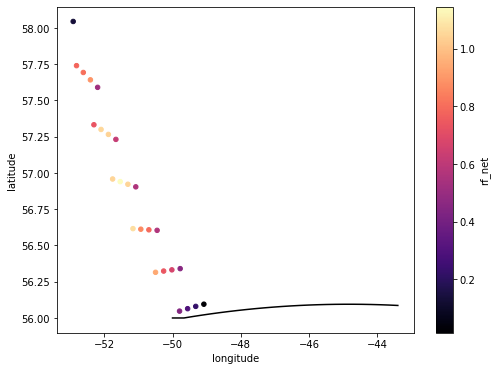

In [74]:
# plot flight and contrail waypoints together
# contrail color indicates net radiative forcing of the contrail segment
ax = flight.dataframe.plot(x="longitude", y="latitude", color="k", legend=False, figsize=(8, 6))
_ = cocip.contrail.plot.scatter(x="longitude", y="latitude", c="rf_net", cmap="magma", ax=ax)

In [76]:
# output contrail waypoints as xarray Dataset 
cocip.contrail_dataset

<xarray.Dataset>
Dimensions:                    (timestep: 7, waypoint: 4)
Coordinates:
  * timestep                   (timestep) int64 0 1 2 3 4 5 6
  * waypoint                   (waypoint) int64 21 22 23 24
Data variables: (12/54)
    flight_id                  (timestep, waypoint) object '181231_1057_CKS24...
    formation_time             (timestep, waypoint) datetime64[ns] 2019-01-01...
    time                       (timestep, waypoint) datetime64[ns] 2019-01-01...
    longitude                  (timestep, waypoint) float64 -49.08 ... nan
    latitude                   (timestep, waypoint) float64 56.1 56.08 ... nan
    altitude                   (timestep, waypoint) float64 9.092e+03 ... nan
    ...                         ...
    rf_sw                      (timestep, waypoint) float64 0.0 0.0 ... nan nan
    rf_lw                      (timestep, waypoint) float64 0.01498 ... nan
    rf_net                     (timestep, waypoint) float64 0.01498 ... nan
    persistent                 (timestep, waypoint) object True True ... nan nan
    ef                         (timestep, waypoint) float64 7.307e+07 ... nan
    age_hours                  (timestep, waypoint) float64 0.1406 ... nan